In [1]:
import torch.nn as nn
import polars as pl
from tqdm import tqdm
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [2]:
with open("dataset/4clasess.pkl","rb") as f: ##se carga el dataset con mas de 20 observaciones,sin nans,-inf,inf 
    data = pkl.load(f)
target = [elem["class"] for elem in data]

In [3]:
features = pl.read_csv("data.csv")
features.describe()

statistic,,PeriodLS_v2,Mean,GP_DRW_sigma,GP_DRW_tau,IAR_phi,Amplitude,ExcessVar,Meanvariance,Std,SF_ML_amplitude,id
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",178754.0,178754.0,178754.0,178754.0,178754.0,178754.0,178754.0,178754.0,178754.0,178754.0,178754.0,178754.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",89376.5,22.270092,4.8889e-19,0.568473,7947.423822,0.600156,1.740767,NaN,inf,1.0,1.059425,89376.5
"""std""",51601.979347,95.165108,1.3451e-16,0.574475,268961.446576,0.416557,0.194285,NaN,NaN,2.0873e-16,1.792104,51601.979347
"""min""",0.0,0.050004,-4.8809e-15,2.1405e-7,1.2052e-209,3.3349e-13,0.207087,-inf,-2.8247e19,1.0,-0.5,0.0
"""25%""",44688.0,0.087137,-6.1254e-17,0.000003,0.573813,0.097004,1.610189,-1.9579e32,-1.5012e16,1.0,0.075931,44688.0
"""50%""",89377.0,0.235463,0.0,0.562237,1.081127,0.794922,1.733041,3.4856e31,4.6704e15,1.0,0.948952,89377.0
"""75%""",134065.0,0.997847,6.1254e-17,0.972489,28.263565,0.992502,1.861802,2.2878e32,1.7758e16,1.0,1.530445,134065.0
"""max""",178753.0,904.761832,6.8945e-15,17.762507,5.0229e7,1.0,3.374575,inf,inf,1.0,15.0,178753.0


In [4]:
features = features.drop(["Mean","ExcessVar","Meanvariance","Std","id",""])
features

PeriodLS_v2,GP_DRW_sigma,GP_DRW_tau,IAR_phi,Amplitude,SF_ML_amplitude
f64,f64,f64,f64,f64,f64
0.296472,0.059642,1.819084,0.510499,1.714204,0.112959
0.056712,0.000004,1.437435,0.99171,2.051243,-0.5
0.051169,9.7203e-7,1.293458,1.0,1.887421,-0.5
0.064801,0.141447,19.375533,0.997312,2.064402,0.758753
0.660869,0.000002,1.049287,0.913965,1.640656,0.226225
…,…,…,…,…,…
0.291304,0.994311,0.033928,4.2301e-13,1.695227,1.109116
0.057773,0.000002,0.590208,0.123261,1.848301,15.0
0.318498,1.05257,0.514109,0.177959,1.399494,2.284552


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LightCurveClassifier(nn.Module):
    def __init__(self, input_dim=12, num_classes=4):
        super(LightCurveClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)

        self.out = nn.Linear(32, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn3(self.fc3(x)))
        return self.out(x)


In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Paso 1: Convertir Polars DataFrame y lista de etiquetas
X = features.to_numpy()
y = target  # asegúrate de que sea una lista o array

# Paso 2: Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Paso 3: Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Paso 4: Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Paso 5: Crear datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cuda:1"
model = LightCurveClassifier(input_dim=6, num_classes=4).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
device

'cuda:1'

In [18]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            val_outputs = model(X_val)
            loss = criterion(val_outputs, y_val)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")


Epoch 1/50 - Train Loss: 0.6278 - Val Loss: 0.6013
Epoch 2/50 - Train Loss: 0.6293 - Val Loss: 0.6027
Epoch 3/50 - Train Loss: 0.6289 - Val Loss: 0.6236
Epoch 4/50 - Train Loss: 0.6265 - Val Loss: 0.6261
Epoch 5/50 - Train Loss: 0.6254 - Val Loss: 0.6145
Epoch 6/50 - Train Loss: 0.6261 - Val Loss: 0.6610
Epoch 7/50 - Train Loss: 0.6252 - Val Loss: 0.6244
Epoch 8/50 - Train Loss: 0.6248 - Val Loss: 0.7447
Epoch 9/50 - Train Loss: 0.6244 - Val Loss: 0.6325
Epoch 10/50 - Train Loss: 0.6254 - Val Loss: 0.6101
Epoch 11/50 - Train Loss: 0.6239 - Val Loss: 0.6187
Epoch 12/50 - Train Loss: 0.6227 - Val Loss: 0.6183
Epoch 13/50 - Train Loss: 0.6230 - Val Loss: 0.6303
Epoch 14/50 - Train Loss: 0.6227 - Val Loss: 0.6139
Epoch 15/50 - Train Loss: 0.6229 - Val Loss: 0.6224
Epoch 16/50 - Train Loss: 0.6213 - Val Loss: 0.6279
Epoch 17/50 - Train Loss: 0.6184 - Val Loss: 0.6106
Epoch 18/50 - Train Loss: 0.6193 - Val Loss: 0.6297
Epoch 19/50 - Train Loss: 0.6186 - Val Loss: 0.6217
Epoch 20/50 - Train L

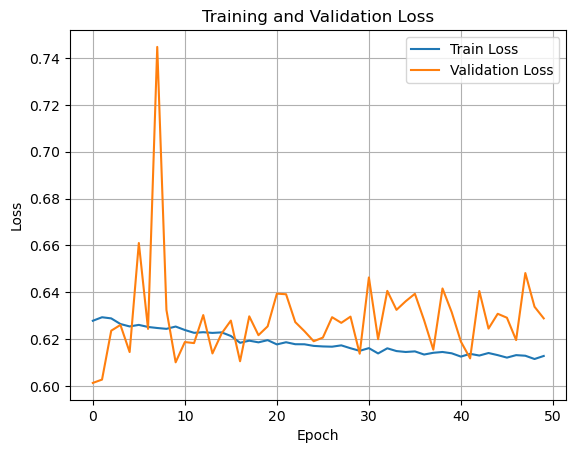

In [19]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
